<a href="https://colab.research.google.com/github/CharlesAntoineVouligny/DeepLearning-with-PyTorch-Lightning/blob/main/FirstDeepLearning_ImageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages (p.38)

In [ ]:
%pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
%pip install pytorch-lightning==1.5.2 --quiet
%pip install opendatasets --upgrade --quiet

In [ ]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

In [ ]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


# Collect data (p.40)

    Kaggle Credentials
    --------------------------------------
    username : charlesavouligny
    key : 5af41fda95112216dda6290dcb66abfa

In [ ]:
dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
od.download(dataset_url)

Skipping, found downloaded files in "./histopathologic-cancer-detection" (use force=True to force download)


In [ ]:
cancer_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Prepare data

In [90]:
# Downsampling the data (p.42)
# Get 10 000 images from the dataset
np.random.seed(5436)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 50000):
  selected_image_list.append(img)
len(selected_image_list)

50000

In [91]:
# Split the extracted data in a training set and a testing set
np.random.seed(5436)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:40000]
cancer_test_idx = selected_image_list[40000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  40000
Number of images in the downsampled testing dataset:  10000


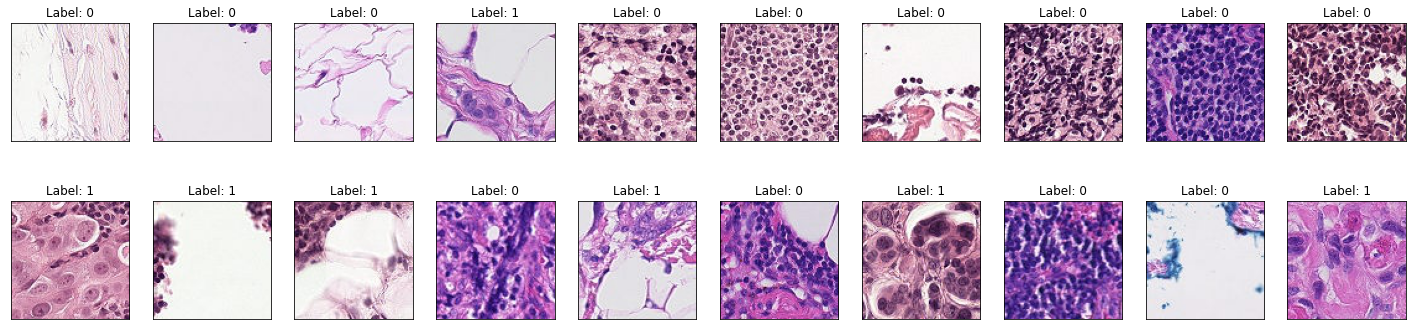

In [92]:
# (What the data looks like - purely informal)
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

# Process data

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
# Transfer local data to persistent storage
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [95]:
# Process data online - train dataset
# os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/train_dataset/")))

No. of images in downsampled training dataset:  37561


In [96]:
# Process data online - test dataset
# os.mkdir('/content/histopathologic-cancer-detection/test_dataset/')
for fname in cancer_test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/test_dataset/")))

No. of images in downsampled testing dataset:  11028


In [97]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

# Loading the dataset (p.45)

In [98]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [99]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,78804584776e250b6391c5410c1e0e65b25a071e,1
1,2287fa27b260fe88edbfb98f64090f9fb3998ca0,1
2,dfbed2cf7b9b72c07f5d439fcf5b49826758f09e,1
3,5a5302111fd9e2e2bd6bcefcc7f54191425da624,0
4,440f28216ecc97d745f550cf9552ead60b7e9938,0


In [100]:
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [101]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [102]:
%%time
# Load train data 
train_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/train_dataset/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 41.1 ms


In [103]:
test_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/test_dataset/', 
                         transform=data_T_test, dict_labels=img_label_dict)

In [104]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

# Building the model (p.47)

In [105]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [106]:
ckpt_dir = "/content/gdrive/MyDrive/Colab Notebooks/test"
model = CNNImageClassifier()

trainer = pl.Trainer(fast_dev_run=True,
                     default_root_dir=ckpt_dir,
                     gpus=1)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------

Training: 0it [00:00, ?it/s]

In [107]:
ckpt_dir = "/content/gdrive/MyDrive/Colab Notebooks/cnn"
# ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CNNImageClassifier()
trainer = pl.Trainer(
    default_root_dir=ckpt_dir,
                     gpus=-1,
                    #  progress_bar_refresh_rate=30,
                    #     callbacks=[ckpt_callback],
                        log_every_n_steps=2,
                        max_epochs=10)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Tot

Training: 0it [00:00, ?it/s]

In [108]:
trainer.test(test_dataloaders=test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/gdrive/MyDrive/Colab Notebooks/cnn/lightning_logs/version_11/checkpoints/epoch=2-step=440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/gdri

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7426550388336182}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.7426550388336182}]

In [109]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [110]:
test_preds = pd.DataFrame({'imgs': test_set.list_image_files, 'labels':test_set.labels,  'preds': preds})


In [111]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])


In [112]:
test_preds.head()

,imgs,labels,preds
0,37b88e926db5455fc5d4e34580cd971bbbc6129f,1,0.542502
1,f14971c79ead1267fa751e64a5d7a4f95374a2a9,0,-1.109095
2,201a62b654526e2e7ab842e21b816f061bfc2fa4,0,-1.037276
3,d75a8334bc29d93b8debe27105e0da855e6f2bd7,1,-0.228758
4,2cb6244d1087eb6cb5ea7ce4a6caefe5c8f1a68c,1,0.375029


In [113]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

(11028, 4)

In [114]:
test_preds.head()

,imgs,labels,preds,predictions
0,37b88e926db5455fc5d4e34580cd971bbbc6129f,1,0.542502,1
1,f14971c79ead1267fa751e64a5d7a4f95374a2a9,0,-1.109095,0
2,201a62b654526e2e7ab842e21b816f061bfc2fa4,0,-1.037276,0
3,d75a8334bc29d93b8debe27105e0da855e6f2bd7,1,-0.228758,0
4,2cb6244d1087eb6cb5ea7ce4a6caefe5c8f1a68c,1,0.375029,1


In [115]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]


0.7529017047515415